# TEST OF THE R&S FSV3030 SIGNAL AND SPECTRUM ANALYZER

This notebook is dedicated to the test of the R&S FSV3030 signal and spectrum analyzer.
We first try to control the instrument with a qcodes driver.
And we try to assess the performance of the instrument and try to compare it with the R&S FSQ.

In [ ]:
from qcodes.logger.logger import start_all_logging
from cycler import cycler
from time import sleep

import matplotlib.pyplot as plt
import qcodes as qc
import numpy as np
import datetime
import time
import json
import sys
import os

In [18]:

# plotting style
plt.style.use(['paper'])


params_tex = {'text.latex.preamble' :  r'\usepackage{amssymb}'}
plt.rc('text',usetex=True)
plt.rcParams.update(params_tex)

params = {'axes.linewidth' : 2,
          'xtick.major.width' : 2,
          'ytick.major.width' : 2,
          'lines.linewidth' : 2,
          'xtick.major.size' : 6,
          'xtick.minor.size' : 1.5,
          'xtick.minor.width' : 2,
          'ytick.minor.size' : 3,
          'ytick.major.size' : 6,
          'ytick.minor.width' : 2}

plt.rcParams.update(params)

# %matplotlib widget

In [2]:
sys.path.append('C:\QCodes_Driver_And_Scripts\Drivers')

from RS_FSV import RS_FSV

try:
    FSV = RS_FSV('rs_fsv', 'TCPIP0::192.168.10.66::inst0::INSTR')

except KeyError as er:
    
    RS_FSV.close_all() #Disconnect and irreversibly tear down the instrument
    FSV =  RS_FSV('rs_fsv', 'TCPIP0::192.168.10.66::inst0::INSTR')


Connected to: Rohde&Schwarz FSV3030 (serial:1330.5000K30/101509, firmware:1.60) in 0.06s


In [3]:
__file__ = 'test_fsv.ipynb'

start_all_logging()

# Create a station
station = qc.Station()
station.add_component(FSV)

station.snapshot()
station.components

description='FSV_single_trace'
date=datetime.datetime.today().strftime('%Y_%m_%d')

database_name = date+"_"+description

script_dir=os.path.dirname(__file__)
data_dir=os.path.join('C:\\QCodes_Driver_And_Scripts\\Data_QCodes\\Dorian\\'+date)

try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

data_dir=data_dir +'\\'+description

try :
    os.mkdir(data_dir)
except FileExistsError:
    pass



Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\wiebke.guichard\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\wiebke.guichard\.qcodes\logs\220111-13184-qcodes.log


In [4]:
qc.initialise_or_create_database_at(data_dir+'\\'+database_name)
qc.config.core.db_location

parameter_snap={}

In [37]:

def measure_single_trace(exp,station):

    meas = qc.Measurement(exp=exp, station=station)
    meas.register_parameter(FSV.freq_axis)
    meas.register_parameter(FSV.spectrum,setpoints=[FSV.freq_axis])

    with meas.run() as datasaver:

        id=datasaver.dataset.run_id
        qc.load_by_run_spec( captured_run_id=id).add_metadata('parameter_snap',
                             json.dumps(parameter_snap))

        datasaver.add_result((FSV.freq_axis, FSV.freq_axis()),(FSV.spectrum,FSV.spectrum()))

## Trying single frequency sweep

## With monochromatic tone

In [35]:
rBW         = 100.*1e3                #Hz
vBW         = 0.3*1e3                 #Hz
aver_num    = 1
span        = 10e6                    #Hz
npoint      = int(span/rBW) + 1
center_freq = 3 * 1e9                 #Hz
ref_lvl     = 0                       #dBm

# Snapshot parameters
parameter_snap['FSV'] = {'center':center_freq, 'span':span, 'npoint': npoint,
                         'ref_lvl':ref_lvl,'rBW':rBW,'vBW':vBW,
                         'average':aver_num}


In [36]:

FSV.res_BW(rBW)
FSV.video_BW(vBW)
FSV.center_freq(center_freq)
FSV.averages(aver_num)
# FSQ.n_points(npoint)
FSV.span(span)
FSV.ref_level(ref_lvl)
FSV.average_type('vid')

trace_time=float(FSV.sweep_time())

print('\ntime for one trace : {} s\n'.format(datetime.timedelta(seconds=trace_time)))


time for one trace : 0:00:15.400000 s



In [38]:

# Load experiment
exp_name = 'FSV_single_trace'

sample_name = 'B3_G3SQ100R1_RKTWPA'

exp=qc.load_or_create_experiment(experiment_name=exp_name,
                          sample_name=sample_name)

measure_single_trace(exp=exp, station=station)


Starting experimental run with id: 3. 


In [40]:
captured_run_id=3

# load dataset corresponding to the run
dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)
# print instrument parameters
parameter=json.loads(dataset.get_metadata('parameter_snap'))
print(parameter)


exp_name=dataset.exp_name


{'FSV': {'center': 3000000000.0, 'span': 10000000.0, 'npoint': 101, 'ref_lvl': 0, 'rBW': 100000.0, 'vBW': 300.0, 'average': 1}}


In [41]:
data = dataset.get_parameter_data('rs_fsv_spectrum')['rs_fsv_spectrum']['rs_fsv_spectrum']
freq = dataset.get_parameter_data('rs_fsv_freq_axis')['rs_fsv_freq_axis']['rs_fsv_freq_axis'][0]*1e-9

parameter_snap = json.loads(dataset.get_metadata('parameter_snap'))


Text(0.5, 1.0, '2022_01_11_FSV_single_trace\nFSV_single_trace  [B3_G3SQ100R1_RKTWPA]  (id: 3)\n')

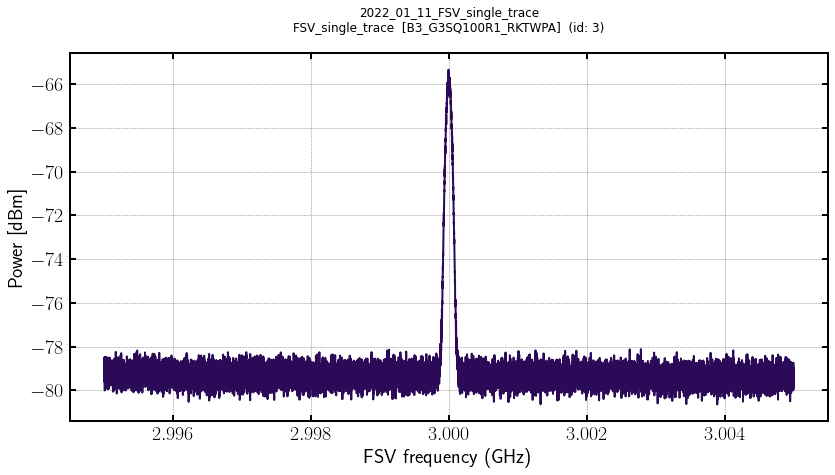

In [42]:
#Figure and axes
fig, ax = plt.subplots(1,1,sharex=True,figsize=(12,7))
ax.set_xlabel('FSV frequency (GHz)')
ax.set_ylabel('Power [dBm]')
ax.axes.grid(True,linestyle="--")

clr = plt.cm.inferno(np.linspace(0.15,0.6,3))
custom_cycler = cycler(color=clr)
ax.set_prop_cycle(custom_cycler)

ax.plot(freq,data[0,:],'-')

plot_title  = database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name
plot_title += ']  (id: '+str(captured_run_id)+')\n' 
ax.set_title(plot_title, size=12,usetex=False)


## Trying 0 span sweep

In [72]:
rBW         = 100.*1e3                #Hz
vBW         = 0.3*1e3                 #Hz
aver_num    = 1
span        = 0                       #Hz
npoint      = 10001
center_freq = 3 * 1e9                 #Hz
ref_lvl     = 0                       #dBm

# Snapshot parameters
parameter_snap['FSV'] = {'center':center_freq, 'span':span, 'npoint': npoint,
                         'ref_lvl':ref_lvl,'rBW':rBW,'vBW':vBW,
                         'average':aver_num}


In [190]:

FSV.res_BW(rBW)
FSV.video_BW(vBW)
FSV.center_freq(center_freq)
FSV.averages(aver_num)
FSV.n_points(npoint)
FSV.span(span)
FSV.ref_level(ref_lvl)
FSV.average_type('vid')

time = npoint / vBW * 5. 
FSV.sweep_time(time)

trace_time=float(FSV.sweep_time())

print('\ntime for one trace : {} s\n'.format(datetime.timedelta(seconds=trace_time)))


time for one trace : 0:02:46.683333 s



In [191]:

# Load experiment
exp_name = 'FSV_single_trace'

sample_name = 'B3_G3SQ100R1_RKTWPA'

exp=qc.load_or_create_experiment(experiment_name=exp_name,
                          sample_name=sample_name)

measure_single_trace(exp=exp, station=station)


Starting experimental run with id: 20. 


In [192]:
captured_run_id=20

# load dataset corresponding to the run
dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)
# print instrument parameters
parameter=json.loads(dataset.get_metadata('parameter_snap'))
print(parameter)


exp_name=dataset.exp_name


{'FSV': {'center': 3000000000.0, 'span': 0, 'npoint': 10001, 'ref_lvl': 0, 'rBW': 100000.0, 'vBW': 300.0, 'average': 1}}


In [193]:
data_8 = dataset.get_parameter_data('rs_fsv_spectrum')['rs_fsv_spectrum']['rs_fsv_spectrum']
freq_8 = dataset.get_parameter_data('rs_fsv_freq_axis')['rs_fsv_freq_axis']['rs_fsv_freq_axis'][0]*1e-9

parameter_snap = json.loads(dataset.get_metadata('parameter_snap'))


Text(0.5, 1.0, '2022_01_11_FSV_single_trace\nFSV_single_trace  [B3_G3SQ100R1_RKTWPA]  (id: 20)\n')

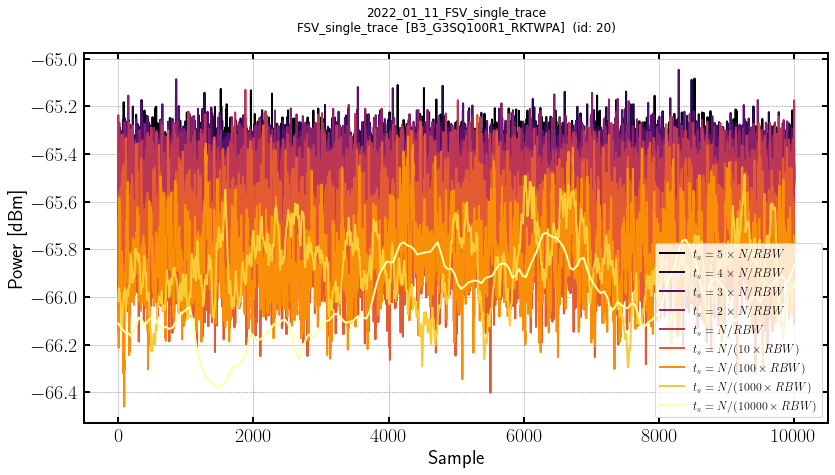

In [203]:
#Figure and axes
fig, ax = plt.subplots(1,1,sharex=True,figsize=(12,7))
ax.set_xlabel('Sample')
ax.set_ylabel('Power [dBm]')
ax.axes.grid(True,linestyle="--")

clr = plt.cm.inferno(np.linspace(0.0,1.0,9))
custom_cycler = cycler(color=clr)
ax.set_prop_cycle(custom_cycler)

ax.plot(data_8[0,:],'-',label=r'$ t_s=5 \times N/RBW$')
ax.plot(data_7[0,:],'-',label=r'$ t_s=4 \times N/RBW$')
ax.plot(data_6[0,:],'-',label=r'$ t_s=3 \times N/RBW$')
ax.plot(data_5[0,:],'-',label=r'$ t_s=2 \times N/RBW$')
ax.plot(data[0,:],'-',label=r'$t_s=N/RBW$')
ax.plot(data_1[0,:],'-',label=r'$t_s=N/ (10 \times RBW)$')
ax.plot(data_2[0,:],'-',label=r'$t_s=N/ (100 \times RBW)$')
ax.plot(data_3[0,:],'-',label=r'$t_s=N/ (1000 \times RBW)$')
ax.plot(data_4[0,:],'-',label=r'$t_s=N/ (10000 \times RBW)$')




ax.legend(loc='best',fontsize = 12)

plot_title  = database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name
plot_title += ']  (id: '+str(captured_run_id)+')\n' 
ax.set_title(plot_title, size=12,usetex=False)


In [199]:
len(data[0])

10001

In [1]:
mean  = np.array([np.mean(data_8[0,:]),np.mean(data_7[0,:]),np.mean(data_6[0,:]),np.mean(data_5[0,:]),np.mean(data[0,:]),np.mean(data_1[0,:]),np.mean(data_2[0,:]),np.mean(data_3[0,:]),np.mean(data_4[0,:])])
ratio = np.array([5.,4.,3.,2.,1.,1/10.,1/100.,1/1000.,1/10000.])

NameError: name 'np' is not defined

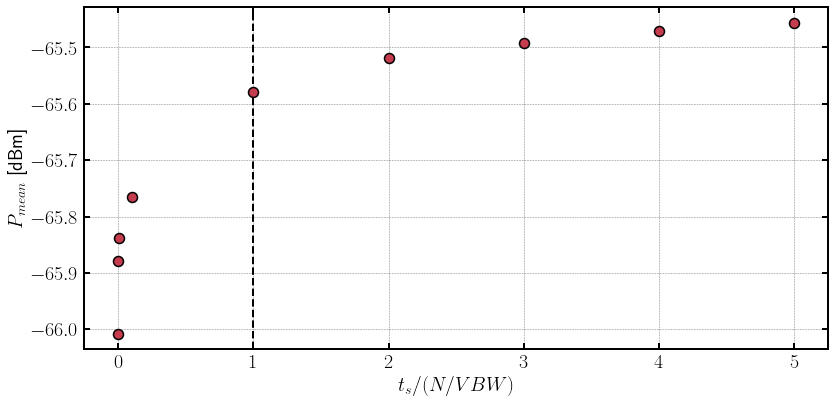

In [207]:
#Figure and axes
fig, ax = plt.subplots(1,1,sharex=True,figsize=(12,6))
ax.set_xlabel(r'$t_s/(N/VBW)$')
ax.set_ylabel('$P_{mean}$ [dBm]')
ax.axes.grid(True,linestyle="--")

ax.axvline(1.,linestyle='--',color='k')

clr = plt.cm.inferno(np.linspace(0.15,0.9,5))
custom_cycler = cycler(color=clr)
ax.set_prop_cycle(custom_cycler)

ax.plot(ratio,mean,'o',color=clr[2],markersize=10,markeredgecolor='k',markeredgewidth=1.5)

plt.savefig('zerospan.jpg')
